### Regime Identification in Multivariate Time-series

In [113]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
import regimes
import numpy as np
import pandas as pd
import seaborn as sns
from clasp import ClaSP
import datasets as dataset
from scipy import stats
from spdms import getSPDMs
from scipy.stats import norm
from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

np.random.seed(1)

In [115]:
# Normalization (Standard)
def normalize(data, type='minmax'):

    if type=='std':
        return (np.array(data) - np.mean(data))/np.std(data)
        
    elif type=='minmax':
        return (np.array(data) - np.min(data))/(np.max(data) - np.min(data))

In [314]:
# Function to convert timestamp to formatted date
def convert_timestamp(timestamp):
    # Assuming the timestamp format is 'YYMMDD'
    timestamp = str(timestamp)
    year = int(timestamp[:4])
    month = int(timestamp[4:6])
    day = int(timestamp[6:8])

    # Convert to datetime object
    date_obj = datetime(year, month, day)

    # Format the datetime object as 'DD-Mon-YYYY'
    formatted_date = date_obj.strftime('%d-%b-%Y')

    return formatted_date

In [315]:
def add_date_column(dataframe, starting_date):
    """
    Add a 'date' column to the DataFrame based on the 'day' column and starting date.

    Parameters:
    - dataframe: DataFrame with a 'day' column representing the day of the year.
    - starting_date: Starting date in the format 'DD-MMM-YYYY' (e.g., '01-Jan-2001').

    Returns:
    - DataFrame with the added 'date' column.
    """
    # Number of samples in the data
    num_samples = len(dataframe)

    # Convert the starting date to a datetime object
    start_date = pd.to_datetime(starting_date, format="%d-%b-%Y")

    # Add a new 'date' column based on 'day', 'month', and dynamically assigned 'year'
    dataframe['Date'] = (start_date + pd.to_timedelta(dataframe.index, unit='D')).strftime("%d-%b-%Y")

    return dataframe

In [316]:
# Function to trim time part from date string and use month names abbreviation
def trim_time_and_format(date_string):
    datetime_object = datetime.strptime(date_string, "%d-%b-%Y") # "%Y-%m-%d %H:%M:%S"
    return datetime_object #.strftime("%Y %b")

In [666]:
# Load data
file_path = r"/home/ahmad/Projects/gCause/datasets/fluxnet2015/FLX_FR-Pue_FLUXNET2015_SUBSET_2000-2014_2-4/FLX_FR-Pue_FLUXNET2015_SUBSET_DD_2000-2014_2-4.csv"  # Replace with the actual file path
# file_path = r'../datasets/synthetic_datac.csv'
data = regimes.read_file(file_path)
start_date = '01-Jan-2002'
end_date ='31-Dec-2002'
col_list = ['TIMESTAMP', 'SW_IN_F', 'TA_F', 'GPP_NT_VUT_50', 'RECO_NT_VUT_50']
# Convert the 'date' column to datetime objects
data['TIMESTAMP'] = data['TIMESTAMP'].apply(convert_timestamp)

data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])
data = data[(data['TIMESTAMP'] >= start_date) & (data['TIMESTAMP'] <= end_date)][col_list]

# # # -------------- FLUXNET2015-----------------------
# offset = 365
# start, end = 2*offset , 3*offset

# df = {'R$_g$': rg[start: end], 'T$_{air}$': temp[start: end], 'GPP': gpp[start: end], 'R$_{eco}$': reco[start: end]}   # 
# data = pd.DataFrame(df, columns=['R$_g$', 'T$_{air}$', 'GPP', 'R$_{eco}$'])  #, 'GPP', 'R$_{eco}$'
# # -------------------------------------------------


In [667]:
if len(data.columns)==1:
    data = regimes.shift_and_fill_mean(data, 3)
data

,TIMESTAMP,SW_IN_F,TA_F,GPP_NT_VUT_50,RECO_NT_VUT_50
731,2002-01-01,39.520,1.469,1.497140,1.17799
732,2002-01-02,27.295,2.691,1.233890,1.26954
733,2002-01-03,7.616,4.341,0.306711,1.42968
734,2002-01-04,3.647,4.068,0.176032,1.44458
735,2002-01-05,36.795,4.177,1.474480,1.49326
...,...,...,...,...,...
1091,2002-12-27,5.758,10.693,0.250619,2.25751
1092,2002-12-28,31.920,9.762,1.794080,2.15810
1093,2002-12-29,40.913,10.379,2.376970,2.22032
1094,2002-12-30,22.266,7.965,1.148520,1.97749


In [668]:
# # Apply the function to the entire column
# time_column_exist, col_name = regimes.find_time_related_columns(data)
# print(time_column_exist, col_name)
# if time_column_exist:
#     data['Date'] = data['Date'].apply(trim_time_and_format)

In [669]:
data.set_index('TIMESTAMP', inplace=True)
data.head()

,SW_IN_F,TA_F,GPP_NT_VUT_50,RECO_NT_VUT_50
TIMESTAMP,,,,
2002-01-01,39.520,1.469,1.497140,1.17799
2002-01-02,27.295,2.691,1.233890,1.26954
2002-01-03,7.616,4.341,0.306711,1.42968
2002-01-04,3.647,4.068,0.176032,1.44458
2002-01-05,36.795,4.177,1.474480,1.49326


In [670]:
# start, end = '2014-11-01', '2016-12-30'

# Appy mask get a segment from time series
# mask = (data['DateTime'] > '2014-11-01') & (data['DateTime'] <= '2015-12-28')
# data = data.loc[mask]

# data = data.fillna(method='pad')
# data = data.set_index('DateTime')
# data = data[start: end]
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2002-01-01 to 2002-12-31
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SW_IN_F         365 non-null    float64
 1   TA_F            365 non-null    float64
 2   GPP_NT_VUT_50   365 non-null    float64
 3   RECO_NT_VUT_50  365 non-null    float64
dtypes: float64(4)
memory usage: 14.3 KB


In [671]:
data.isnull().sum()

SW_IN_F           0
TA_F              0
GPP_NT_VUT_50     0
RECO_NT_VUT_50    0
dtype: int64

In [672]:
# Loop through columns and fill NaN values with mean
for column in data.columns:
    if data[column].isnull().any():
        mean_value = data[column].mean()
        data[column].fillna(mean_value, inplace=True)

In [673]:
# data = data.dropna(how='any',axis=0) 
# data = data.drop(columns=['Date'])
columns = data.columns
data.isnull().sum()

SW_IN_F           0
TA_F              0
GPP_NT_VUT_50     0
RECO_NT_VUT_50    0
dtype: int64

In [674]:
# toplot = ['Z1', 'Z2','Z5']
# data = data[toplot]
# data.head()

In [675]:
data = data.apply(normalize)

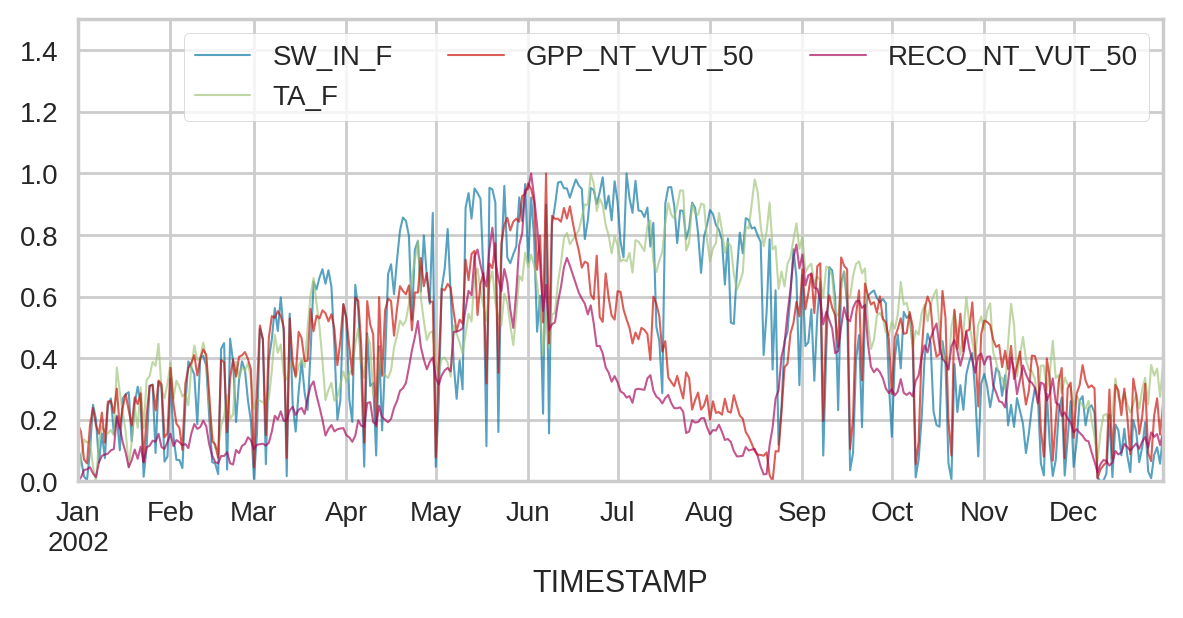

In [676]:
# toplot = [ 'rain', 'snow_load', 'pressure_outside','gw_mb', 'gw_sg', 'gw_west', 'strain_ns_corrected']
# toplot = ['gw_mb', 'gw_sg', 'temperature_outside', 'strain_ew_corrected', 'strain_ns_corrected']
toplot = ['Z1', 'Z2','Z5']
toplot = columns

for i in toplot:
    data[i].plot(use_index=True, figsize=(7, 3), linewidth=0.75, alpha=0.66)
    plt.legend(toplot, frameon=True, ncol=3)

plt.ylim(0, 1.5)
# plt.gcf().autofmt_xdate()
# plt.legend(['Temperature', 'Ground Water', 'Strain_EW', 'Strain_NS'])
# plt.legend(['$Z_{1}$', '$Z_{2}$', '$Z_{3}$'])
# plt.savefig("synreg25Apr.png")
plt.show()

In [681]:
# Desired number of clusters. Set k=None to let the algorithm aumotically find opitmal k.
k = 3      # k=None

# Sliding window size
winsize = 21 # 155

# distance metrics
metricE = 'Euclidean'
metricR = 'Riemannian'

# Specify reduced dimension size, default is dim='full' for no dimension reduction.
dim = 'full' 

# Retrieve regimes with their corresponding indices
clusters, cluster_idx, *_ = regimes.get_regimes(data, winsize, metricR, k, dim)

Regimes:(1, 0) (1, 21) (1, 42) (2, 63) (2, 84) (2, 105) (2, 126) (2, 147) (0, 168) (0, 189) (0, 210) (2, 231) (2, 252) (2, 273) (1, 294) (1, 315) (1, 336)


In [682]:
clusters_extended = []

for i in range(len(clusters)):

    val = clusters[i]
    for j in range(winsize):
        clusters_extended.append(val)
        
        
print(len(clusters_extended), data.shape)

357 (365, 4)


In [683]:
datanew = data.iloc[:len(clusters_extended), :].copy()
datanew['Clusters'] = clusters_extended

<Figure size 3000x800 with 0 Axes>

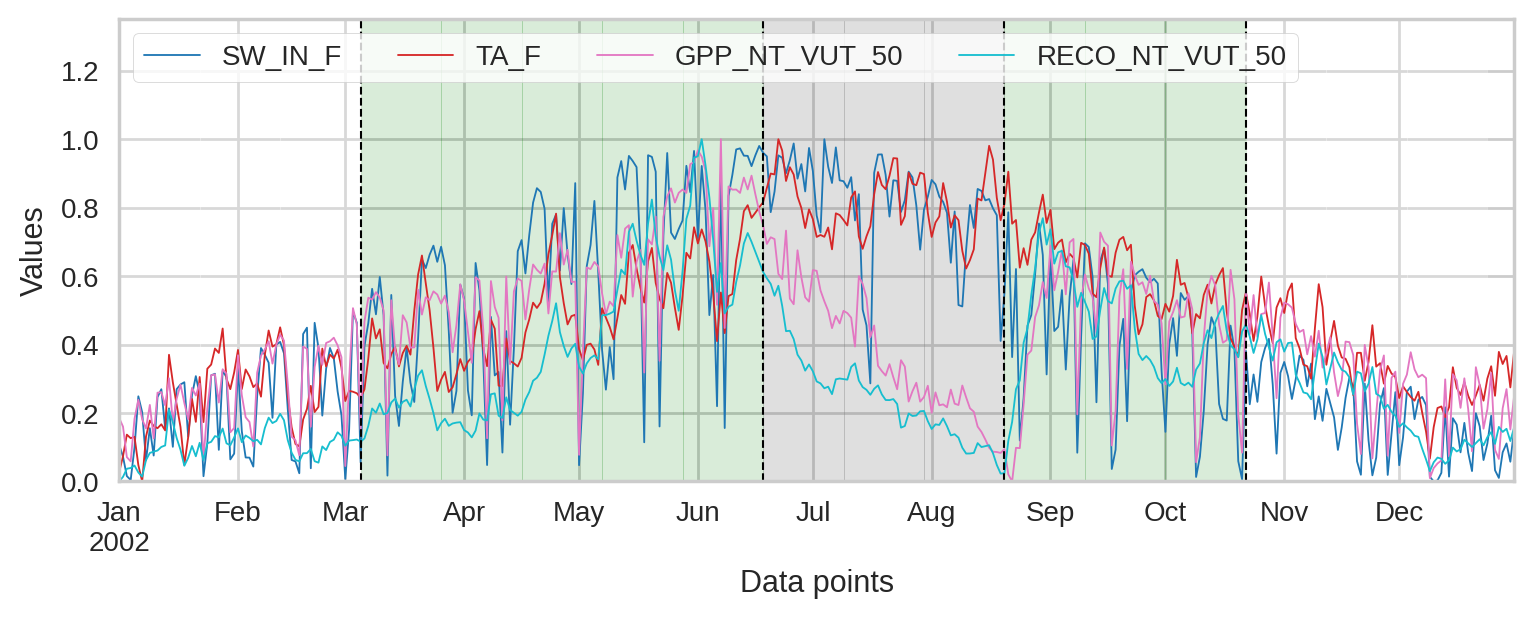

In [684]:
var_to_plot = toplot
regimes.visualize(data, var_to_plot, clusters, cluster_idx, winsize, dtype='real')